# Data Ordering attack on Stochastic Gradient Descent


## Motivation

This attack is based on the paper "Manipulating SGD with Data Ordering Attacks" (https://arxiv.org/abs/2104.09667) by Shumailov, Shumaylov, Kazhdan, Zhao, Papernot, Erdogdu and Anderson.


## Explanation

The idea behind this attack is to reorder batches within a data feed to a machine learning model using Stochastic Gradient Descent (SGD). This form of adversarial machine learning exploits SGD's behaviour to attack the model's integrity and availability.


## Simple Attack


### Setup

The attack environment will be using the Abalone Dataset (http://archive.ics.uci.edu/ml) using linear SGD classification with ```sklearn.linear_model.SGDClassifier``` (https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html) to predict a tree's number of rings (i.e. its age) based on other features about the tree. \
*Note: The 'sex' feature of the Abalone Dataset has been omitted throughout this algorithm and is not considered by any of the models.*

1. Import necessary libraries.
2. Define configuration values.
3. Load the Abalone Dataset.
4. Apply PCA to the dataset to visualise the data on a 2D plane.
5. Split the dataset into feature vectors ~(tree information) and their corresponsing class labels (the tree's age in years).
6. Initialise control, training and surrogate ```SGDClassifier``` models.
7. Train the models over one epoch for a partial fit of each model with the dataset.

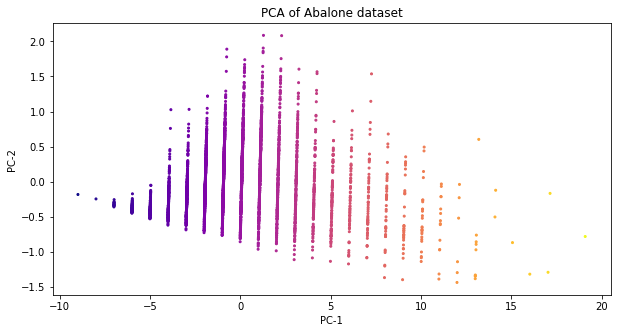

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import hinge_loss
from sklearn.decomposition import PCA

# Configuration values
HIGH_LOW = 'HIGH -> LOW'
LOW_HIGH = 'LOW -> HIGH'
OSC_IN = 'OSCILLATE IN'
OSC_OUT = 'OSCILLATE OUT'
BATCH_REORDER = 'REORDER'
BATCH_RESHUFFLE = 'RESHUFFLE'

N_TESTDATA_SAMPLES = 150
NUM_ITER = 1000
N = 1476

# Read the abalone.data file into a pandas dataframe
df = pd.read_csv('abalone.data')

# Declare what our feature vectors and class vectors are
features = ['sex', 'length', 'diameter', 'height', 'whole_weight', 'shucked_weight', 'viscera_weight', 'shell_weight', 'rings']
classVector = 'rings'


# Assign a header/title to each feature
df.set_axis(features, axis=1, inplace=True)
features.remove('sex')


# Visualise the data on a 2D plane through PCA dimensionality reduction
pca = PCA(n_components=2)
pcs = pca.fit(df[features]).components_
reducedData = np.matmul((df[features]-df[features].mean()).to_numpy(), pcs.transpose())
dfReduced = pd.DataFrame(data=reducedData, columns=['PC-1', 'PC-2'])
plt.scatter(reducedData[:, 0], reducedData[:, 1], s=4, c=df[classVector].to_list(), cmap='plasma')

plt.xlabel('PC-1')
plt.ylabel('PC-2')
plt.title('PCA of Abalone dataset')
plt.gcf().set_size_inches(10, 5)
plt.show()



# Split dataset into a training dataset and testing dataset
trainingData = df[features][:-N_TESTDATA_SAMPLES]
trainingLabels = df[classVector][:-N_TESTDATA_SAMPLES]

testData = df[features][-N_TESTDATA_SAMPLES:]
testLabels = df[classVector][-N_TESTDATA_SAMPLES:]


# Initialise control, target and surrogate models.
control = target = surrogate = None

def init_models():
    global control, target, surrogate
    # Create identical SGD Classifier control and target models
    control = SGDClassifier(loss='log', penalty='elasticnet', tol=0.001, shuffle=False, random_state=0, learning_rate='constant', eta0=0.2)
    target = SGDClassifier(loss='log', penalty='elasticnet', tol=0.001, shuffle=False, random_state=0, learning_rate='constant', eta0=0.2)

    # Surrogate model which the attacker is using to predict Iris classification, different configuration to the control/target models
    surrogate = SGDClassifier(loss='hinge', tol=0.001, shuffle=False, random_state=0, learning_rate='constant', eta0=0.2)

    # Get a numpy array of all possible class labels in dataset
    classLabels = np.unique(df[classVector].to_numpy())

    # Train the models over one epoch of datapoints in a currently natural non-malicious order
    control.partial_fit(X=trainingData, y=trainingLabels, classes=classLabels)
    surrogate.partial_fit(X=trainingData, y=trainingLabels, classes=classLabels)
    target.partial_fit(X=trainingData, y=trainingLabels, classes=classLabels)



### Utility Sorting Methods [WORK IN PROGRRESS, NOT IMPLEMENTED YET]
Uses Radix Sort (LSD) to order data batches in ascending order of surrogate model loss (based on implementation at https://stackabuse.com/radix-sort-in-python/). Previously python's built-in ```sorted()``` function based on a TimSort, but this has time complexity $O(n log n)$ for $n$ elements which is much slower than Radix Sort with time complexity $O(d(n + k))$ with $n$ elements where the largest element is $d$ digits long of base $k$ (in this case, $k = 10$). This Radix Sort implementation is specific for handling a dictionary where the keys are each data point's ID and the values are the data point's loss, outputting the data points in ascending order of loss.

In [7]:
def counting_dict(data, order):
    indecies = list(data.keys())
    losses = list(data.values())


    # List to store cumulative base-10 digit frequency
    count = [0] * 10

    n = len(data)
    
    # Read digit of selected order (digit place) and update frequency of this digit
    for i in losses:
        digit = (i // order) % 10
        count[digit] += 1
    
    # Reformat count to use prefix sum to work out element placement later
    for i in range(1, 10):
        count[i] += count[i-1]

    # Sorted list of data points in ascending order of surrogate loss
    indeciesSorted = [None] * n
    lossesSorted = [None] * n

    # Sort
    for i in range(n - 1, -1, -1):
        # Read loss digit of selected order, decrement this digit frequency by 1
        # Use the updated value as the index to allocate for this data point
        digit = (losses[i] // order) % 10
        count[digit] -= 1
        pos = count[digit]
        indeciesSorted[pos] = indecies[i]
        lossesSorted[pos] = losses[i]

    dataSorted = dict(zip(indeciesSorted, lossesSorted))
    
    return dataSorted

def counting_dict2(data):
    indecies = list(data.keys())
    losses = list(data.values())

    n = len(data)
    max_i = max(losses)
    
    count = [0] * max_i

    for i in losses:
        count[i-1] += 1
    
    for i in range(1, max_i):
        count[i] += count[i-1]
    
    indeciesSorted = [None] * n
    lossesSorted = [None] * n

    for i in range(n):
        count[losses[i]-1] -= 1
        pos = count[losses[i]-1]
        indeciesSorted[pos] = indecies[i]
        lossesSorted[pos] = losses[i]

    dataSorted = dict(zip(indeciesSorted, lossesSorted))

    return dataSorted



maxmax_i = 0

def radix_dict(data):
    # Find largest element in the loss scores
    max_i = max(data.values())
    global maxmax_i
    maxmax_i = max(max_i, maxmax_i)

    # Calculate number of digits in largest element
    d = 0
    while int(max_i) > 0:
        max_i /= 10
        d += 1

    # Initialise digit place
    digitPlace = 1

    # Sort the data with counting sort, repeat for d digits, multiply digit places by 10 at each iteration
    dataSorted = data
    while d > 0:
        dataSorted = counting_dict(dataSorted, digitPlace)
        digitPlace *= 10
        d -= 1

    return dataSorted
    



In [8]:
dictionary = {'it': 551, 'doesnt': 553, 'matter': 31}
counting_dict2(dictionary)

{'matter': 31, 'it': 551, 'doesnt': 553}

### Reorder data to attack

The data is reordered based on the specified attack type and the data is then fed in this order into the target and surrogate models. The control model's ordering is not altered by the algorithm. This model is not needed in an actual attack and is only being used in this experiment as a control model for data analysis and comparison after running the algorithm.


In [80]:
# TO DO: Fix batch size reordering

#===== ATTACK =====
def attack(attackType, batchSizes, NUM_BATCHES, oscSize=1):

    # Stores read data points and their class labels BEFORE reordering
    data = []

    # Stores a data point's corresponding label
    labels = []

    # Stores a data point's index from data as a key, and this data point's loss on surrogate as value
    datacosts = {}
    
    start = 0
    classLabels = np.unique(df[classVector].to_numpy())

    for i in range(NUM_BATCHES):
        # Read each data batch, evaluate the loss
        batchSize = batchSizes[i]
        batch = trainingData.iloc[start:start+batchSize]
        batchLabels = trainingLabels.iloc[start:start+batchSize]
        loss = hinge_loss(batchLabels, surrogate.decision_function(batch), labels=classLabels)

        # Record values
        data.append(batch)
        labels.append(batchLabels)
        datacosts[i] = loss

        start += batchSize

    
    # Reorder data batch indecies by ascending order of loss
    reorderedCosts = dict(sorted(datacosts.items(), key = lambda item: item[1]))

    # Store a list of each data batch and corresponding class label AFTER reordering
    reorderedData = []
    reorderedLabels = []
    # reorderedBatchSizes = []

    # Reorder data batches and their classes based on redordered indecies
    for index in reorderedCosts:
        reorderedData.append(data[index])
        reorderedLabels.append(labels[index])
        # reorderedBatchSizes.append(batchSizes[index])

    # Invert each half of reordered data if oscillating out attack type
    if attackType == OSC_OUT:
        right = reorderedData[len(reorderedData)//2:][::-1]
        left = reorderedData[:len(reorderedData)//2][::-1]
        reorderedData = left + right

        right = reorderedLabels[len(reorderedLabels)//2:][::-1]
        left = reorderedLabels[:len(reorderedLabels)//2][::-1]
        reorderedLabels = left + right
        
        # right = reorderedLabels[len(reorderedLabels)//2:][::-1]
        # left = reorderedLabels[:len(reorderedLabels)//2][::-1]
        # reorderedLabels = left + right

    # Reverse order of reordered data if high -> low attack type
    if attackType == HIGH_LOW:
        for i in range(len(reorderedData)):
            reorderedData[i] = reorderedData[i][::-1]
        reorderedLabels = reorderedLabels[::-1]
    
    # Alternate between low and high loss batch if oscillating attack type
    if attackType == OSC_IN or attackType == OSC_OUT:
        osc = False # looking at head if true
        head = 0
        tail = N
        oscillatedData = [None] * N
        oscillatedLabels = [None] * N
        i = 0
        while head < tail:
            osc = not osc
            if osc:
                # batchSize = batchSizes[i]
                # oscBatchSize = min(batchSize * oscSize, tail - head)
                oscBatchSize = sum(batchSizes[i:i+oscSize])
                oscillatedData[i:i+oscBatchSize] = reorderedData[head:head+oscBatchSize]
                oscillatedLabels[i:i+oscBatchSize] = reorderedLabels[head:head+oscBatchSize]
                head += oscBatchSize
            else:
                # batchSize = batchSizes[-i]
                # oscBatchSize = min(batchSize * oscSize, tail - head)
                oscBatchSize = sum(batchSizes[i:i+oscSize])
                oscillatedData[i:i+oscBatchSize] = reorderedData[tail-oscBatchSize:tail]
                oscillatedLabels[i:i+oscBatchSize] = reorderedLabels[tail-oscBatchSize:tail]
                tail -= oscBatchSize
            i += 1
        reorderedData = oscillatedData
        reorderedLabels = oscillatedLabels
    
    # Reformat batch data and labels into one large pandas dataframe for data and labels each
    reorderedData = pd.concat(reorderedData)
    reorderedLabels = pd.concat(reorderedLabels)
    
    # Train control model over one epoch using unaffected data order
    control.partial_fit(X=trainingData, y=trainingLabels)

    # Train target and surrogate models over one epoch using reordered data
    target.partial_fit(X=reorderedData, y=np.ravel(reorderedLabels))
    surrogate.partial_fit(X=reorderedData, y=np.ravel(reorderedLabels))

### Attacking SGD

#### Reordering each individual data point (data batch size = 1)

Attack is carried out four times, using different ordering methods (```LOW_HIGH```, ```HIGH_LOW```, ```OSC_IN```, ```OSC_OUT```). This is repeated ```NUM_ITER``` times, with the accuracies of the target and control models being recorded at every iteration.

In [56]:
accuracies = {}

# Keep track of accuracy data of control and target models for different attack order variants
accuracies['1'] = {
    LOW_HIGH: {'CONTROL': [], 'TARGET': []},
    HIGH_LOW: {'CONTROL': [], 'TARGET': []},
    OSC_IN: {'CONTROL': [], 'TARGET': []},
    OSC_OUT: {'CONTROL': [], 'TARGET': []}
}

# For each order variant, carry out the respective attack for a given number of epochs
for i in (LOW_HIGH, HIGH_LOW, OSC_IN, OSC_OUT):
    # Initialise the models, train them over one epoch in an untampered order
    init_models()

    for j in range(NUM_ITER):
        attack(i, [1] * N, N)

        # Record accuracy data from control and target models
        accuracies['1'][i]['CONTROL'].append(control.score(testData, testLabels) * 100)
        accuracies['1'][i]['TARGET'].append(target.score(testData, testLabels) * 100)

[   length  diameter  height  whole_weight  shucked_weight  viscera_weight  \
0    0.35     0.265    0.09        0.2255          0.0995          0.0485   

   shell_weight  rings  
0          0.07      7  ,    length  diameter  height  whole_weight  shucked_weight  viscera_weight  \
3    0.33     0.255    0.08         0.205          0.0895          0.0395   

   shell_weight  rings  
3         0.055      7  ,     length  diameter  height  whole_weight  shucked_weight  viscera_weight  \
15   0.355      0.28   0.085        0.2905           0.095          0.0395   

    shell_weight  rings  
15         0.115      7  ,     length  diameter  height  whole_weight  shucked_weight  viscera_weight  \
17   0.365     0.295    0.08        0.2555           0.097           0.043   

    shell_weight  rings  
17           0.1      7  ,     length  diameter  height  whole_weight  shucked_weight  viscera_weight  \
44    0.39     0.295   0.095         0.203          0.0875           0.045   

    shell_

KeyboardInterrupt: 

### Data Analysis

The following test is for reordering data batches of size 1, i.e. reordering each data point individually.
1. Plot a graph of the difference in accuracy between control and target models versus the number of iterations (epochs) of training on the model.
2. Output the epoch with the largest accuracy change. 

[LOW -> HIGH] The peak accuracy change is 30.67% and occurs after 13 epochs.
[HIGH -> LOW] The peak accuracy change is 30.67% and occurs after 121 epochs.
[OSCILLATE IN] The peak accuracy change is 30.67% and occurs after 76 epochs.
[OSCILLATE OUT] The peak accuracy change is 30.67% and occurs after 13 epochs.


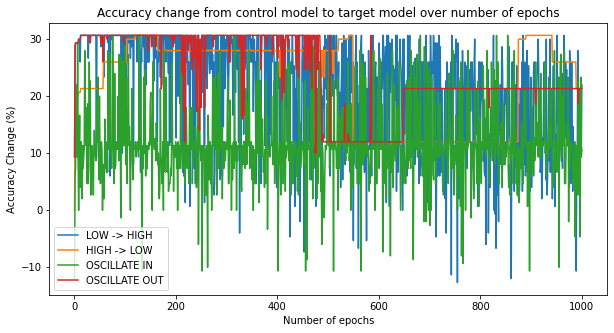

In [11]:
# Plot graph of accuracy variation with number of iterations during training
for i in (LOW_HIGH, HIGH_LOW, OSC_IN, OSC_OUT):
    difference = np.array(accuracies['1'][i]['CONTROL']) - np.array(accuracies['1'][i]['TARGET'])
    plt.plot(range(1, NUM_ITER+1), difference, label=i)

    # Output numerical information on highest accuracy change potential for each attack variation
    print("[%s] The peak accuracy change is %.*f%% and occurs after %d epochs." % (i, 2, np.max(difference), np.argmax(difference)+1))

# Annotate and resize graph
plt.xlabel('Number of epochs')
plt.ylabel('Accuracy Change (%)')
plt.title('Accuracy change from control model to target model over number of epochs')
plt.gcf().set_size_inches(10, 5)
plt.legend()
plt.show()

#### Key Observations:

1. The graph shows the accuracies of the control and target models are different: target is on average ~22% (maximum 30.67%) less accurate in classifying Abalone testing data samples than the control model.
2. The ordering approach affects the classification accuracy: ```OSCILLATE IN``` seems to be less effective at attacking the target model.
3. The ```OSCILLATE IN``` and ```LOW -> HIGH``` reordering methods frequently drop to negative changes (minimum -12.67%), **suggesting that the targeted model is in fact more accurate than the control model**.

### Attack + graphing utility function (can be skipped)

In [72]:
def attack_models(batchSizes, attackName, strategies=[LOW_HIGH, HIGH_LOW, OSC_IN, OSC_OUT], oscSize=1):
    accuracy = {
        LOW_HIGH: {'CONTROL': [], 'TARGET': []},
        HIGH_LOW: {'CONTROL': [], 'TARGET': []},
        OSC_IN: {'CONTROL': [], 'TARGET': []},
        OSC_OUT: {'CONTROL': [], 'TARGET': []}
    }

    for i in strategies:
        init_models()
        
        for j in range(NUM_ITER):
            attack(i, batchSizes, NUM_BATCHES, oscSize=oscSize)
            accuracy[i]['CONTROL'].append(control.score(testData, testLabels) * 100)
            accuracy[i]['TARGET'].append(target.score(testData, testLabels) * 100)
    
    accuracies[attackName] = accuracy
    
    # Plot graph of accuracy variation with number of iterations during training
    for i in strategies:
        difference = np.array(accuracy[i]['CONTROL']) - np.array(accuracy[i]['TARGET'])
        plt.plot(range(1, NUM_ITER+1), difference, label=i)

        # Output numerical information on highest accuracy change potential for each attack variation
        print("[%s] The peak accuracy change is %.*f%% and occurs after %d epochs." % (i, 2, np.max(difference), np.argmax(difference)+1))

    # Annotate and resize graph
    plt.xlabel('Number of epochs')
    plt.ylabel('Accuracy Change (%)')
    plt.title('Accuracy change from control model to target model over number of epochs')
    plt.gcf().set_size_inches(10, 5)
    plt.legend()
    plt.show()

### Reordering Data Batches



#### Batches of random size (between 1 and 32 inclusive)

The attack has been confirmed when feeding the data to the models in batches of size 1 (i.e. model is trained on each data point individually). Does batch size have an effect? The following attack will batch the training data into random sizes between 1 and 32 inclusive and use these batches in the attack.

**NOTE:** a seed has been used to generate determinstic random output for the purposes of these experiments

[13, 16, 22, 1, 4, 28, 4, 8, 10, 20, 22, 19, 5, 24, 7, 25, 25, 13, 27, 2, 7, 8, 24, 15, 25, 18, 6, 26, 14, 9, 10, 21, 20, 17, 20, 6, 31, 16, 16, 1, 19, 4, 25, 18, 20, 30, 20, 20, 15, 8, 1, 2, 10, 26, 1, 11, 21, 24, 4, 31, 12, 19, 24, 29, 3, 1, 1, 5, 22, 6, 7, 9, 21, 18, 16, 5, 10, 11, 27, 25, 2, 2, 8, 10, 26, 4, 7, 24, 12, 15, 19, 28, 1, 15, 4, 22, 13, 26, 11, 21, 12, 5, 3]
[LOW -> HIGH] The peak accuracy change is 30.67% and occurs after 13 epochs.
[HIGH -> LOW] The peak accuracy change is 22.00% and occurs after 247 epochs.
[OSCILLATE IN] The peak accuracy change is 30.67% and occurs after 15 epochs.
[OSCILLATE OUT] The peak accuracy change is 30.67% and occurs after 17 epochs.


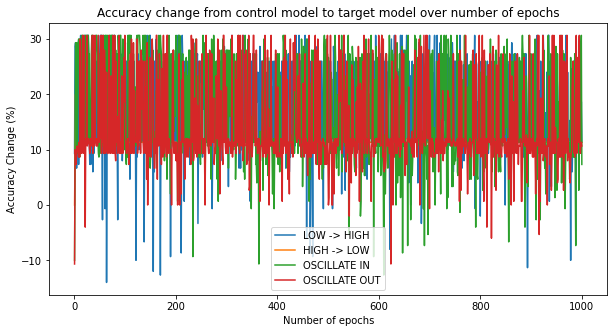

In [30]:
# For determinstic random output
np.random.seed(seed=0)

# Generate determinstic (for purposes of this project's context) random numbers to represent example batch sizes
MAX_BATCH_SIZE = 32
batchSizes = []
count = N
while count > 0:
    r = min(np.random.randint(1, MAX_BATCH_SIZE), count)
    batchSizes.append(r)
    count -= r

print(batchSizes)

NUM_BATCHES = len(batchSizes)
attack_models(batchSizes, 'random')


#### Batches of size 2

To observe any noticeable changes between individual and paired data point batches.

[LOW -> HIGH] The peak accuracy change is 30.67% and occurs after 14 epochs.
[HIGH -> LOW] The peak accuracy change is 30.67% and occurs after 621 epochs.
[OSCILLATE IN] The peak accuracy change is 30.67% and occurs after 13 epochs.
[OSCILLATE OUT] The peak accuracy change is 30.67% and occurs after 147 epochs.


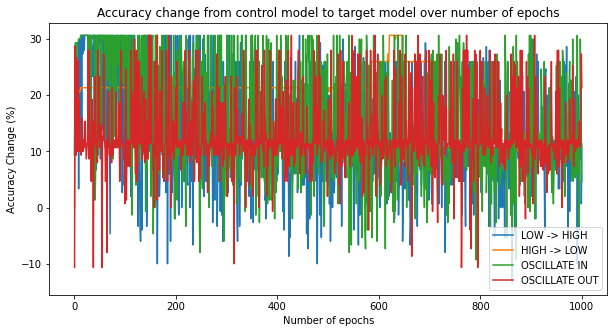

In [14]:
batchSizes = [2] * 738
NUM_BATCHES = len(batchSizes)
attack_models(batchSizes, '2')

#### Batches of size 9

[LOW -> HIGH] The peak accuracy change is 30.67% and occurs after 15 epochs.
[HIGH -> LOW] The peak accuracy change is 30.67% and occurs after 26 epochs.
[OSCILLATE IN] The peak accuracy change is 30.67% and occurs after 13 epochs.
[OSCILLATE OUT] The peak accuracy change is 30.67% and occurs after 21 epochs.


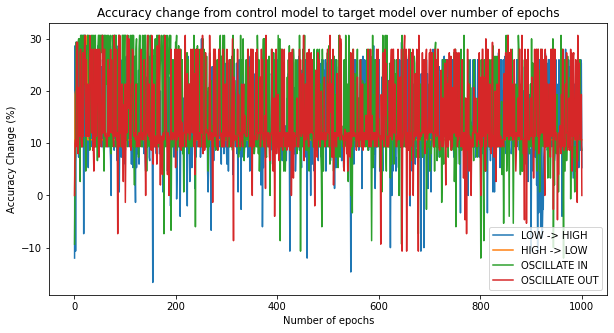

In [15]:
batchSizes = [9] * 164
NUM_BATCHES = len(batchSizes)
attack_models(batchSizes, '9')

#### Batches of size 82

[LOW -> HIGH] The peak accuracy change is 30.67% and occurs after 13 epochs.
[HIGH -> LOW] The peak accuracy change is 30.67% and occurs after 14 epochs.
[OSCILLATE IN] The peak accuracy change is 30.67% and occurs after 14 epochs.
[OSCILLATE OUT] The peak accuracy change is 30.67% and occurs after 14 epochs.


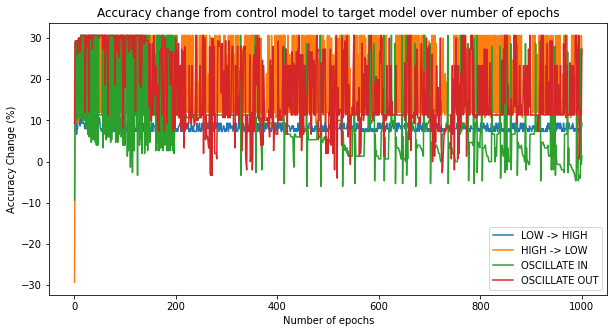

In [59]:
batchSizes = [82] * 18
NUM_BATCHES = len(batchSizes)
attack_models(batchSizes, '82')

In [28]:
print("===Analysis===")
for i in accuracies.keys():
    print("\n\n[BATCH SIZE: %s]" % i)

    for j in (LOW_HIGH, HIGH_LOW, OSC_IN, OSC_OUT):
        difference = np.array(accuracies[i][j]['CONTROL']) - np.array(accuracies[i][j]['TARGET'])
        print("[%s] Maximal change: %.*f%% after %d epochs - Minimal change: %.*f%% after %d epochs - Average change: %.*f%%" % (j, 2, np.max(difference), np.argmax(difference)+1, 2, np.min(difference), np.argmin(difference)+1, 2, np.average(difference)))


===Analysis===


[BATCH SIZE: 1]
[LOW -> HIGH] Maximal change: 30.67% after 13 epochs - Minimal change: -12.67% after 755 epochs - Average change: 21.01%
[HIGH -> LOW] Maximal change: 30.67% after 121 epochs - Minimal change: 0.00% after 1 epochs - Average change: 22.48%
[OSCILLATE IN] Maximal change: 30.67% after 76 epochs - Minimal change: -12.00% after 1 epochs - Average change: 11.45%
[OSCILLATE OUT] Maximal change: 30.67% after 13 epochs - Minimal change: 9.33% after 1 epochs - Average change: 23.94%


[BATCH SIZE: random]
[LOW -> HIGH] Maximal change: 30.67% after 16 epochs - Minimal change: -18.00% after 412 epochs - Average change: 14.31%
[HIGH -> LOW] Maximal change: 30.67% after 49 epochs - Minimal change: 0.00% after 1 epochs - Average change: 25.56%
[OSCILLATE IN] Maximal change: 30.67% after 13 epochs - Minimal change: -13.33% after 343 epochs - Average change: 18.48%
[OSCILLATE OUT] Maximal change: 30.67% after 17 epochs - Minimal change: -12.67% after 907 epochs - Averag

### Reordering by *sized oscillation*

*Sized oscillation* refers to the idea of the

[LOW -> HIGH] The peak accuracy change is 30.67% and occurs after 13 epochs.
[HIGH -> LOW] The peak accuracy change is 30.67% and occurs after 121 epochs.
[OSCILLATE IN] The peak accuracy change is 30.67% and occurs after 16 epochs.
[OSCILLATE OUT] The peak accuracy change is 30.67% and occurs after 13 epochs.


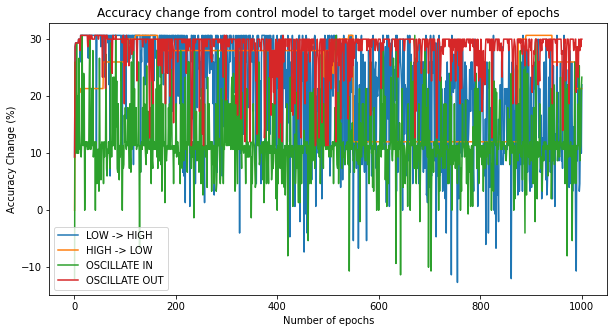

In [82]:
batchSizes = [1] * N
NUM_BATCHES = len(batchSizes)
attack_models(batchSizes, 'sizedOsc_5', oscSize=5)

[LOW -> HIGH] The peak accuracy change is 30.67% and occurs after 13 epochs.
[HIGH -> LOW] The peak accuracy change is 30.67% and occurs after 121 epochs.
[OSCILLATE IN] The peak accuracy change is 30.67% and occurs after 34 epochs.
[OSCILLATE OUT] The peak accuracy change is 30.67% and occurs after 13 epochs.


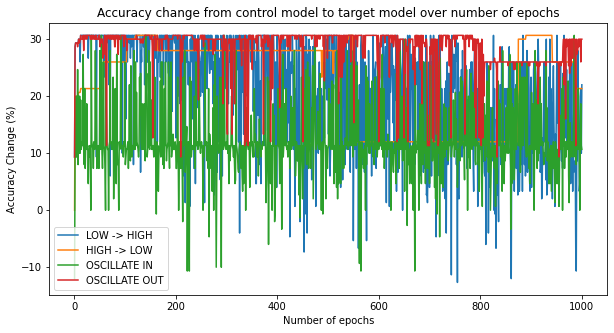

In [68]:
batchSizes = [1] * N
NUM_BATCHES = len(batchSizes)
attack_models(batchSizes, 'sizedOsc_10', strategies=[OSC_IN, OSC_OUT], oscSize=10)

[OSCILLATE IN] The peak accuracy change is 30.67% and occurs after 22 epochs.
[OSCILLATE OUT] The peak accuracy change is 30.67% and occurs after 13 epochs.


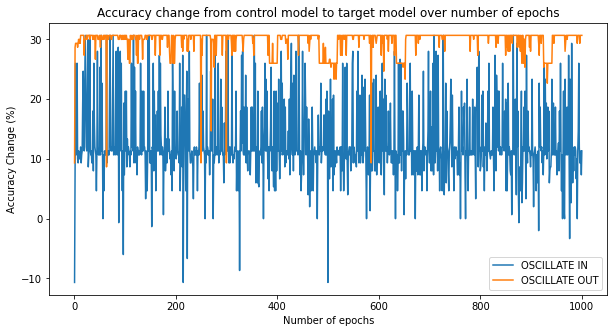

In [83]:
batchSizes = [1] * N
NUM_BATCHES = len(batchSizes)
attack_models(batchSizes, 'sizedOsc_20', strategies=[OSC_IN, OSC_OUT], oscSize=20)

[OSCILLATE IN] The peak accuracy change is 30.67% and occurs after 19 epochs.
[OSCILLATE OUT] The peak accuracy change is 30.67% and occurs after 13 epochs.


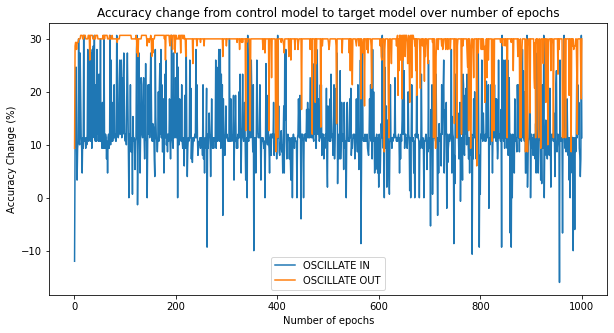

In [73]:
batchSizes = [1] * N
NUM_BATCHES = len(batchSizes)
attack_models(batchSizes, 'sizedOsc_25', strategies=[OSC_IN, OSC_OUT], oscSize=25)

[OSCILLATE IN] The peak accuracy change is 30.67% and occurs after 21 epochs.
[OSCILLATE OUT] The peak accuracy change is 30.67% and occurs after 13 epochs.


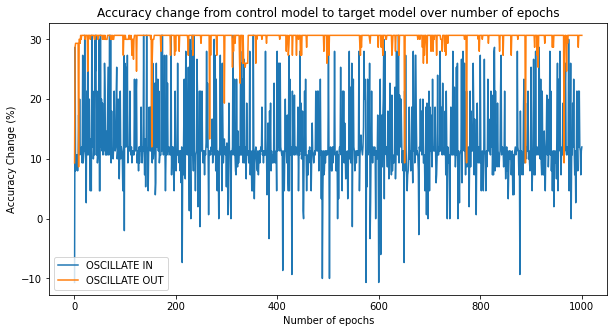

In [84]:
batchSizes = [1] * N
NUM_BATCHES = len(batchSizes)
attack_models(batchSizes, 'sizedOsc_30', strategies=[OSC_IN, OSC_OUT], oscSize=30)

[OSCILLATE IN] The peak accuracy change is 30.67% and occurs after 17 epochs.
[OSCILLATE OUT] The peak accuracy change is 30.67% and occurs after 13 epochs.


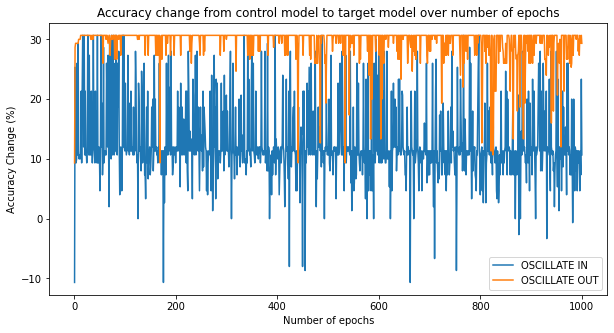

In [85]:
batchSizes = [1] * N
NUM_BATCHES = len(batchSizes)
attack_models(batchSizes, 'sizedOsc_40', strategies=[OSC_IN, OSC_OUT], oscSize=40)

[LOW -> HIGH] The peak accuracy change is 30.67% and occurs after 13 epochs.
[HIGH -> LOW] The peak accuracy change is 30.67% and occurs after 121 epochs.
[OSCILLATE IN] The peak accuracy change is 30.67% and occurs after 37 epochs.
[OSCILLATE OUT] The peak accuracy change is 30.67% and occurs after 13 epochs.


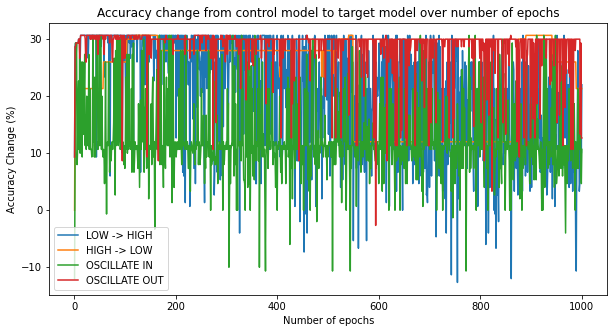

In [69]:
batchSizes = [1] * N
NUM_BATCHES = len(batchSizes)
attack_models(batchSizes, 'sizedOsc_50', strategies=[OSC_IN, OSC_OUT], oscSize=50)

[OSCILLATE IN] The peak accuracy change is 30.67% and occurs after 18 epochs.
[OSCILLATE OUT] The peak accuracy change is 30.67% and occurs after 15 epochs.


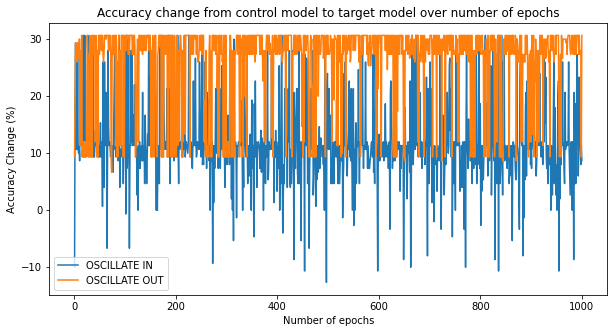

In [74]:
batchSizes = [1] * N
NUM_BATCHES = len(batchSizes)
attack_models(batchSizes, 'sizedOsc_100', strategies=[OSC_IN, OSC_OUT], oscSize=100)

[OSCILLATE IN] The peak accuracy change is 30.67% and occurs after 13 epochs.
[OSCILLATE OUT] The peak accuracy change is 30.67% and occurs after 19 epochs.


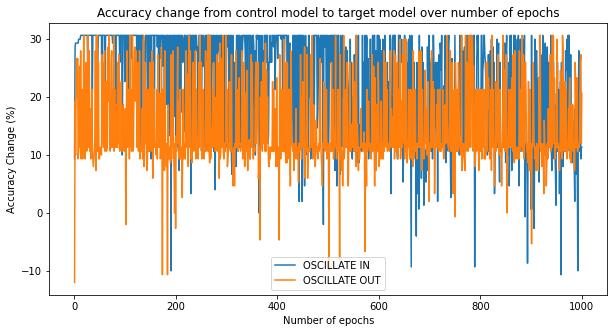

In [78]:
batchSizes = [1] * N
NUM_BATCHES = len(batchSizes)
attack_models(batchSizes, 'sizedOsc_N/2', strategies=[OSC_IN, OSC_OUT], oscSize=int(N/2))

In [86]:
for i in ('sizedOsc_5', 'sizedOsc_10', 'sizedOsc_20', 'sizedOsc_25', 'sizedOsc_40', 'sizedOsc_40', 'sizedOsc_50', 'sizedOsc_100', 'sizedOsc_N/2'):
    print("\n\n[BATCH SIZE: %s]" % i)
    for j in (OSC_IN, OSC_OUT):
        difference = np.array(accuracies[i][j]['CONTROL']) - np.array(accuracies[i][j]['TARGET'])
        print("[%s] Maximal change: %.*f%% after %d epochs - Minimal change: %.*f%% after %d epochs - Average change: %.*f%%" % (j, 2, np.max(difference), np.argmax(difference)+1, 2, np.min(difference), np.argmin(difference)+1, 2, np.average(difference)))




[BATCH SIZE: sizedOsc_5]
[OSCILLATE IN] Maximal change: 30.67% after 16 epochs - Minimal change: -12.00% after 1 epochs - Average change: 11.93%
[OSCILLATE OUT] Maximal change: 30.67% after 13 epochs - Minimal change: 9.33% after 1 epochs - Average change: 28.08%


[BATCH SIZE: sizedOsc_10]
[OSCILLATE IN] Maximal change: 30.67% after 34 epochs - Minimal change: -12.00% after 1 epochs - Average change: 12.42%
[OSCILLATE OUT] Maximal change: 30.67% after 13 epochs - Minimal change: 9.33% after 210 epochs - Average change: 28.36%


[BATCH SIZE: sizedOsc_20]
[OSCILLATE IN] Maximal change: 30.67% after 22 epochs - Minimal change: -10.67% after 215 epochs - Average change: 12.95%
[OSCILLATE OUT] Maximal change: 30.67% after 13 epochs - Minimal change: 8.67% after 64 epochs - Average change: 29.80%


[BATCH SIZE: sizedOsc_25]
[OSCILLATE IN] Maximal change: 30.67% after 19 epochs - Minimal change: -16.00% after 956 epochs - Average change: 12.59%
[OSCILLATE OUT] Maximal change: 30.67% after 